# Roadmap

The goal of this notebook is to provide an example of how compute basin average rainrate for a storm given gridded rainfall fields and a shapefile of the basin

  1. Read gridded rainfall fields from NetCDF files
  2. Accumulate gridded data
  3. Read in shapefile
  4. Reproject to match rainfall fields
  5. Use binary check to see if grids fall within basin
  6. Calculate percentage of each grid cell that falls within the basin
  7. Use weights to get basin averaged storm total rain
  8. Use weights to generate a time series of basin-averaged rain

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [2]:
!cat environment.yml

name: radar
channels:
- conda-forge
- defaults
dependencies:
- python=2.7
- arm_pyart
- basemap
- basemap-data-hires
- matplotlib
- jupyter
- pandas
- numpy
- cython
- wget
- lxml
- pyproj
- pip:
  - skewt
  - git+git://github.com/CSU-Radarmet/CSU_RadarTools.git


## Read gridded rainfall fields from NetCDF files

In [112]:
import os
import numpy as np
import pandas as pd
import pyart

from pyart_radar_tools import *

In [164]:
grid_paths = ['./tmp/{f}'.format(f=f) for f in os.listdir('./tmp') if '.nc' in f]
grid_paths.sort()

In [114]:
nx = 400
ny = 400

rain = np.zeros((ny, nx))
r_z = np.zeros((ny, nx))
r_kdp = np.zeros((ny, nx))
rain_mask = np.zeros((ny, nx))
r_z_mask = np.zeros((ny, nx))
r_kdp_mask = np.zeros((ny, nx))

for grid_path in grid_paths:
    m = pyart.io.read_grid(grid_path)
    #rain
    rain += np.ma.filled(m.fields['rain']['data'][0], 0)
    rain_mask += m.fields['rain']['data'][0].mask
    #r_z
    r_z += np.ma.filled(m.fields['r_z']['data'][0], 0)
    r_z_mask += m.fields['r_z']['data'][0].mask
    #r_kdp
    r_kdp += np.ma.filled(m.fields['r_kdp']['data'][0], 0)
    r_kdp_mask += m.fields['r_kdp']['data'][0].mask

We will find it useful to know both the edges of the grid cells and the centers of the grid cells, lets just be sure we know which ones we are looking at at any given time. We will call them elat, elon, and clat, clon to keep track.

In [115]:
elon, elat = m.get_point_longitude_latitude(edges=True)
clon, clat = m.get_point_longitude_latitude()

## Read in Shapefile

In [124]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
shpfile='./tmp/BasinBoundary/ShortCreek.shp'
shp = Reader(shpfile)

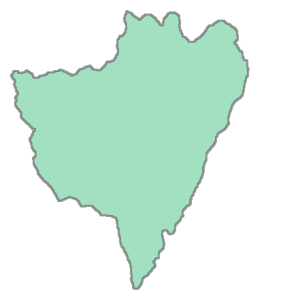

In [118]:
geoms = shp.geometries()
polygon = cascaded_union(list(geoms))
polygon

Let's keep track of the watershed area in km

In [159]:
basin_area = polygon.area/1000000

Check out the projection and try placing the shapefile over the data.

In [119]:
cat ./tmp/BasinBoundary/ShortCreek.prj

PROJCS["NAD_1983_UTM_Zone_12N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-111.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]

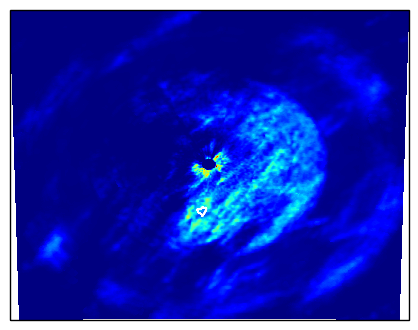

In [120]:
shape_feature = ShapelyFeature(shp.geometries(),
                               ccrs.UTM(12),
                               facecolor='none',
                               edgecolor='white')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
#ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.pcolormesh(elon, elat, rain, transform=ccrs.PlateCarree())

Reproject shapefile from original coordinate system into latlon to match gridded rainfall

In [121]:
from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:26912'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # destination coordinate system
g2 = transform(project, polygon)  # apply projection

We can plot this over the original data to see whether it looks reasonable

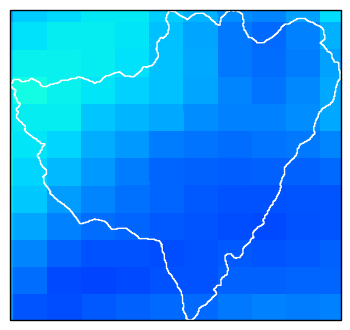

In [122]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
ax.pcolormesh(clon, clat, rain, transform=ccrs.PlateCarree())
ax.set_extent([g2.bounds[0], g2.bounds[2], g2.bounds[1], g2.bounds[3]])

## Use a binary search to check if the center of each cell is in the basin
This idea is based on [this blog post](https://ocefpaf.github.io/python4oceanographers/blog/2015/08/17/shapely_in_polygon/)

In [125]:
def inpolygon(polygon, xp, yp):
    return np.array([Point(x, y).intersects(polygon) for x, y in zip(xp, yp)],
                    dtype=np.bool)

mask1d = inpolygon(g2, clon.ravel(), clat.ravel())
mask2d = mask1d.reshape(clon.shape)

In [126]:
basin_rain = np.ma.masked_array(rain, ~mask2d)

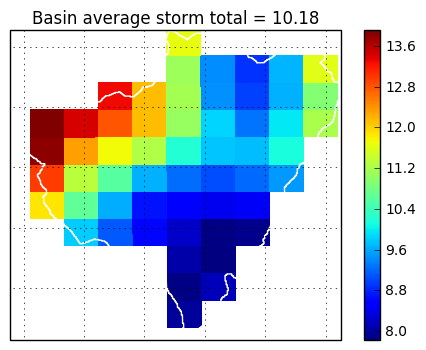

In [131]:
ax = plt.axes(projection=ccrs.PlateCarree())
c = ax.pcolormesh(elon, elat, basin_rain)
ax.set_extent([g2.bounds[0], g2.bounds[2], g2.bounds[1], g2.bounds[3]])
ax.add_feature(shape_feature)
ax.gridlines()
plt.colorbar(c)
plt.title('Basin average storm total = {r:1.2f}'.format(r=basin_rain.mean()));

## Calculate percentages of grid cells
We need to figure out how to do another mask where the resolution is finer. I took some ideas from [this SO question](http://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely). First we will get a rough box arouond the shapefile to limit the number of queries that we need to perform. 

In [135]:
buf = .01

bool_a = ((clon > g2.bounds[0]-buf) & (clon < g2.bounds[2]+buf) &
          (clat > g2.bounds[1]-buf) & (clat < g2.bounds[3]+buf))

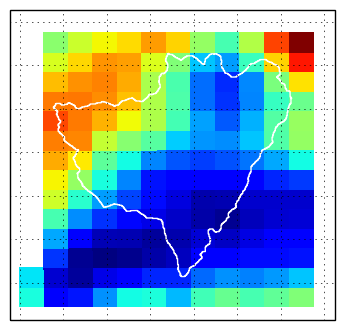

In [136]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
ax.gridlines()
ax.pcolormesh(elon, elat, np.ma.masked_array(rain, ~bool_a))
ax.set_extent([g2.bounds[0]-buf*2, g2.bounds[2]+buf*2, g2.bounds[1]-buf*2, g2.bounds[3]+buf*2])

That worked pretty well! So now we will take just this subset of gridcells and make each one into a shapely.Polygon object. Once we have a list of these Polygons, we can calculate what percentage of each grid cell intersects with our reprojected basin. 

In [158]:
%%time
mp = []
for iy, ix in zip(*np.where(bool_a)):
    mp.append(Polygon([(elon[iy,ix], elat[iy,ix]), 
                       (elon[iy,ix+1], elat[iy,ix+1]),
                       (elon[iy+1,ix+1], elat[iy+1,ix+1]),
                       (elon[iy+1,ix], elat[iy+1,ix])]))

weights = np.array([g2.intersection(p).area/p.area for p in mp])

CPU times: user 1.25 s, sys: 696 µs, total: 1.25 s
Wall time: 1.25 s


Cool! So that wasn't the fastest thing in the world but not so bad either. And now we have all the weights that we need going forward. So if we subset our rain in the same way, all we need to do is multiply by the weights, sum our weighted values, and then divide by the basin area in km to get basin average storm rain.

In [160]:
z = np.array([rain[iy,ix] for iy, ix in zip(*np.where(bool_a))])
weighted_rain = z*weights

storm_total = weighted_rain.sum()/basin_area
print('Basin average storm total = {r:1.2f}'.format(r=storm_total))

Basin average storm total = 10.14


## We can use these same weights to get a basin averaged time series
Now this is accumulations on an irregular frequency, so it probably behooves us to find a clever way to get back to a rate.

In [188]:
totals = []
times = []
for grid_path in grid_paths:
    m = pyart.io.read_grid(grid_path)
    rain = np.ma.filled(m.fields['rain']['data'][0], 0)
    z = np.array([rain[iy,ix] for iy, ix in zip(*np.where(bool_a))])
    weighted_rain = z*weights
    t_tot = weighted_rain.sum()/basin_area
    totals.append(t_tot)
    times.append(pd.Timestamp(grid_path.split('/')[-1][4:19].replace('_', ' ')))

time_series = pd.Series(index=times, data=totals)

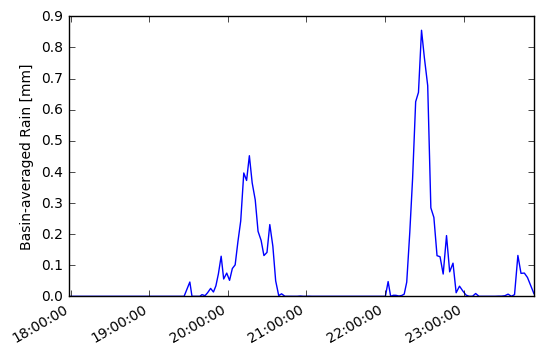

In [192]:
time_series.plot()
plt.ylabel('Basin-averaged Rain [mm]')